# MNIST Classification Using PCA and DNN

## Import All Package

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import save_model

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import pickle

## Load MNIST Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000,-1)
x_test = x_test.reshape(10000,-1)

11490434/11490434 [==============================] - 1s 0us/step


## Apply PCA on MNIST Dataset

In [3]:
tf.random.set_seed(880301)

n_components = 10
epochs = 1000

MNIST_PCA = PCA(n_components = n_components)
MNIST_PCA.fit(x_train)
x_train_pca = MNIST_PCA.transform(x_train)
x_test_pca = MNIST_PCA.transform(x_test)

scaler = MinMaxScaler()
scaler.fit(x_train_pca)
x_train_pca = scaler.transform(x_train_pca)
x_test_pca = scaler.transform(x_test_pca)

print(x_train_pca.shape,x_test_pca.shape)

(60000, 10) (10000, 10)


## Define DNN Model

In [4]:
model = tf.keras.models.Sequential([
    Input(shape=(n_components,)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='softmax')
])

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
Total params: 550
Trainable params: 550
Non-trainable params: 0
_________________________________________________________________


## Train DNN Model

In [5]:
rec = model.fit(x_train_pca, 
            y_train, 
            epochs = epochs, 
            batch_size = 5000, 
            validation_data = (x_test_pca, y_test),
            callbacks=[callback], 
            verbose = 0)

## Plot Confusion Matrix

2/2 [==============================] - 0s 3ms/step
(70000,) (70000,)


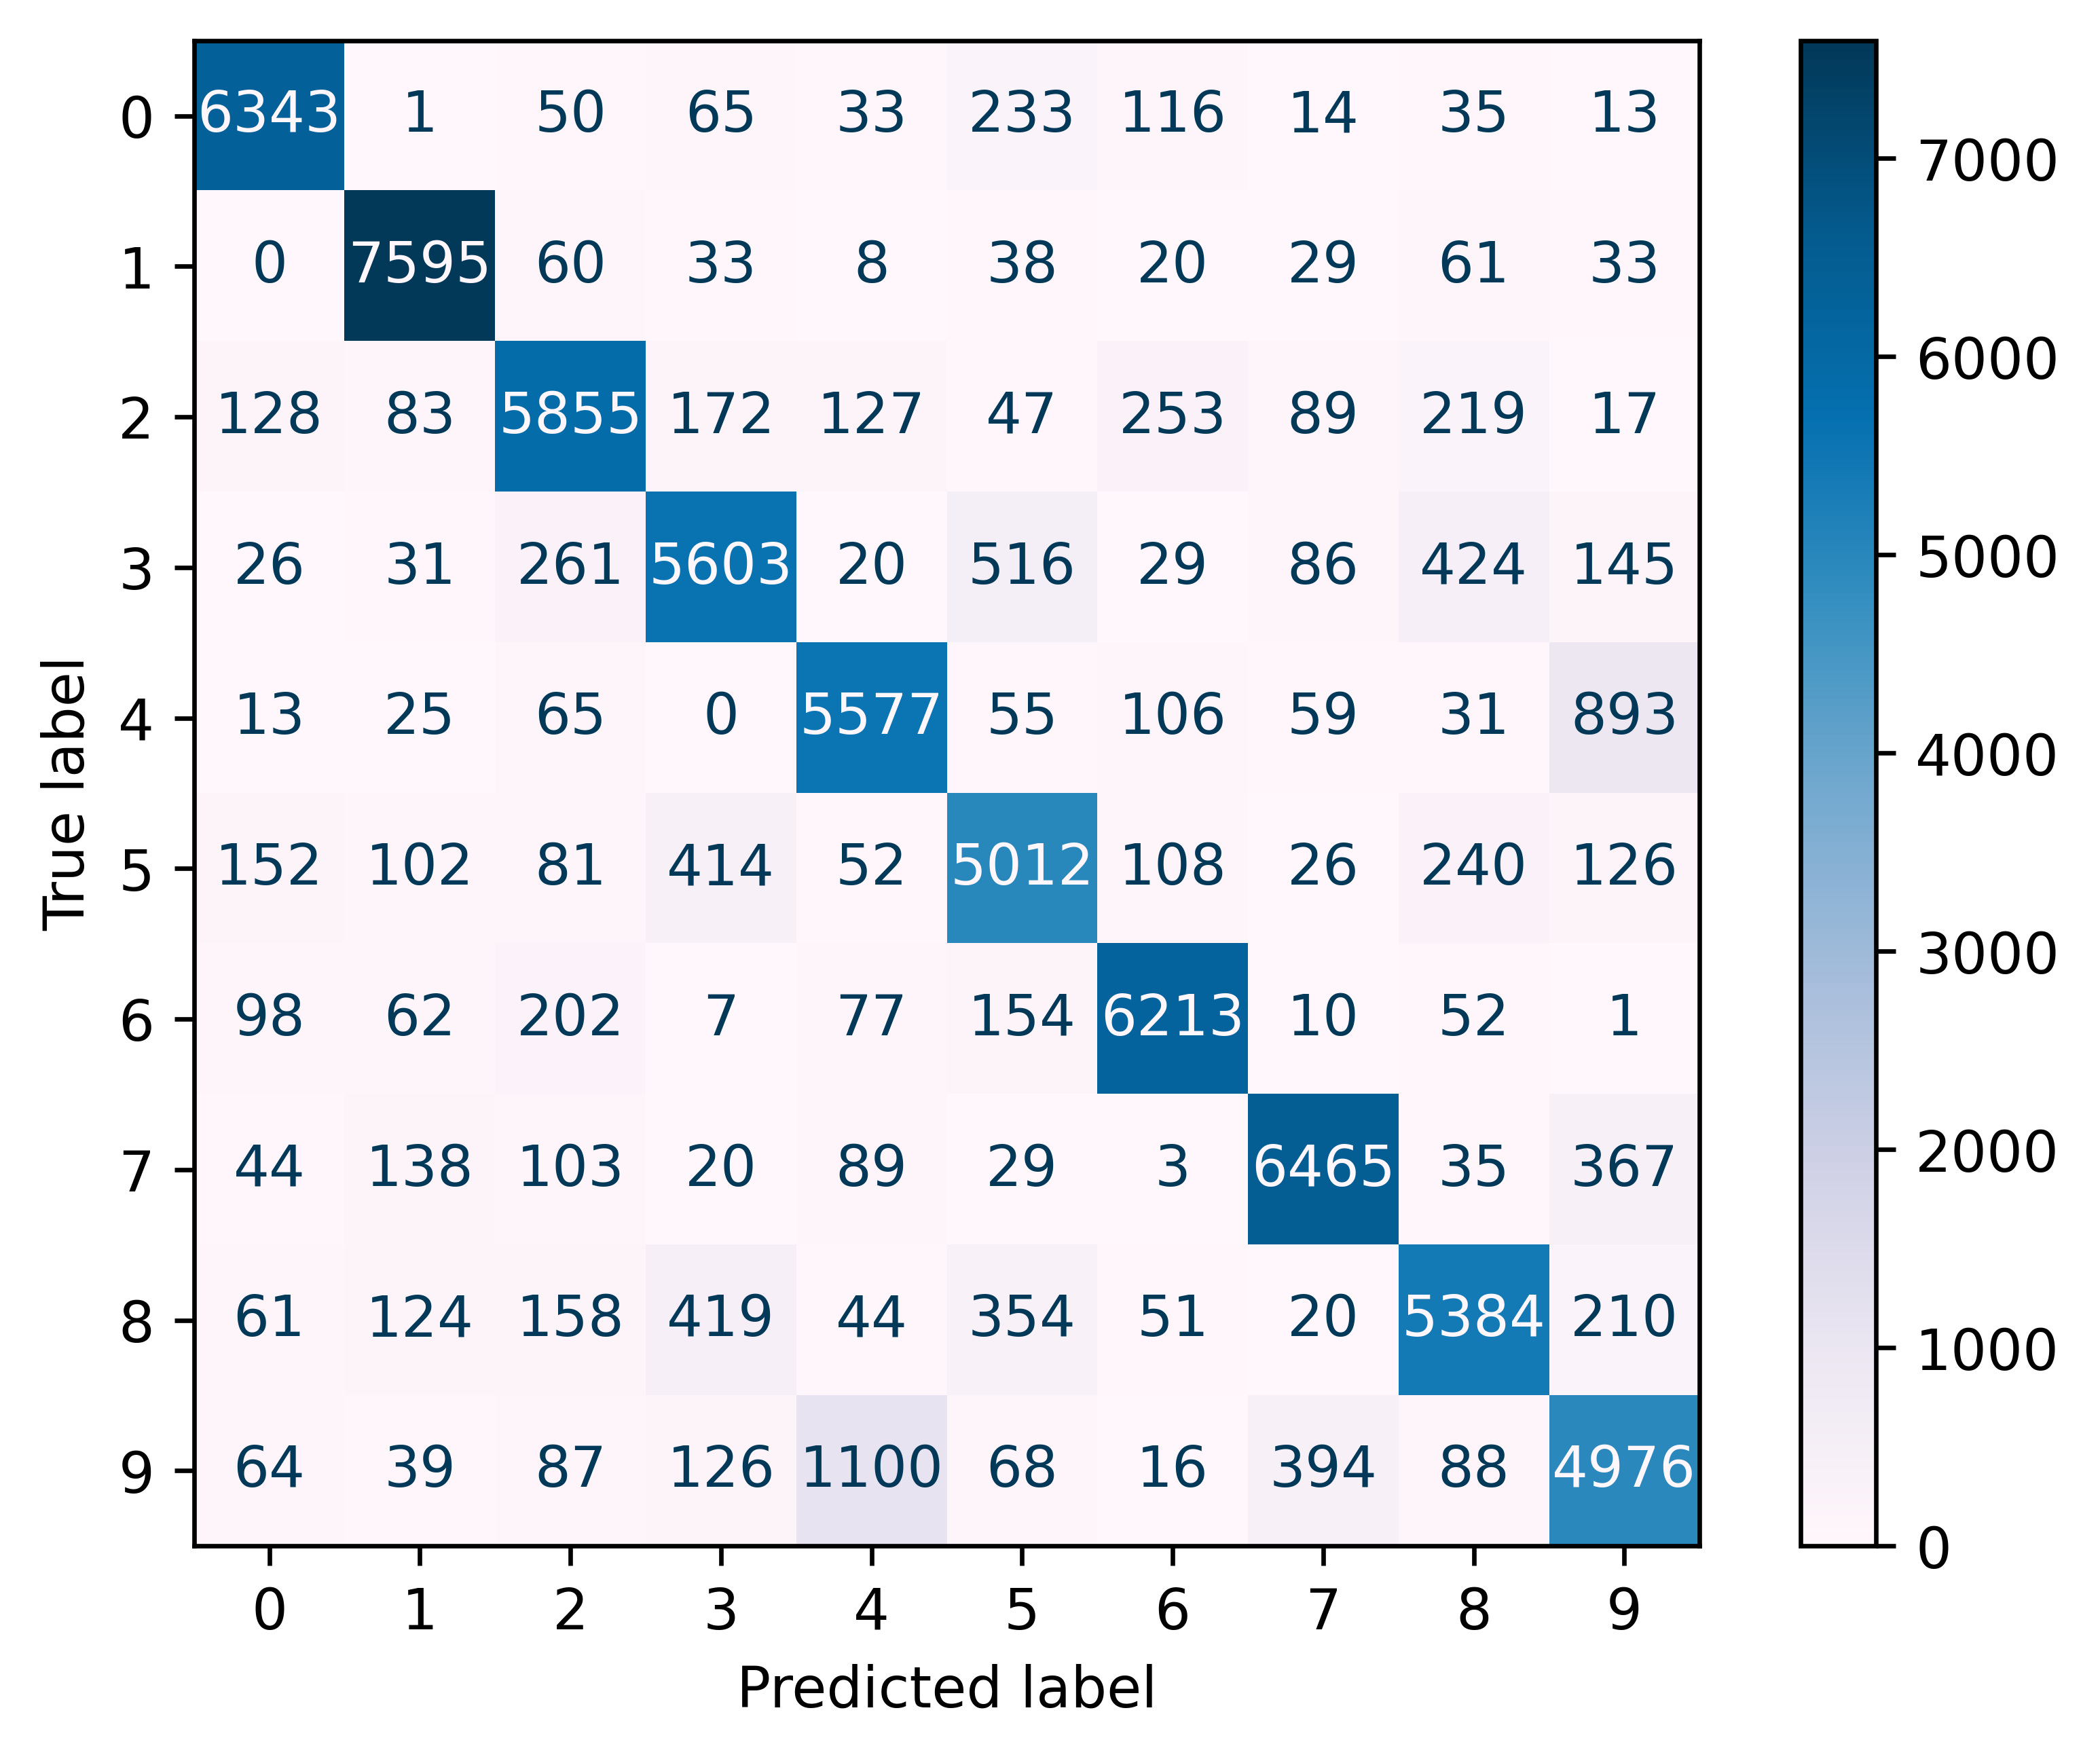

In [6]:
pred_y = np.r_[model.predict(x_train_pca, batch_size = 5000), model.predict(x_test_pca, batch_size = 5000)]
pred_y = np.argmax(pred_y,1)
real_y = np.r_[y_train, y_test]

print(pred_y.shape, real_y.shape)

with open(f'pred_{n_components}.pkl', 'wb') as f:
    pickle.dump((real_y, pred_y),f)

cm = confusion_matrix(real_y, pred_y)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = range(10))

plt.figure(dpi = 600)
ax = plt.subplot()
cm_display.plot(cmap='PuBu', ax=ax)
plt.show()

## Plot Learning Curve

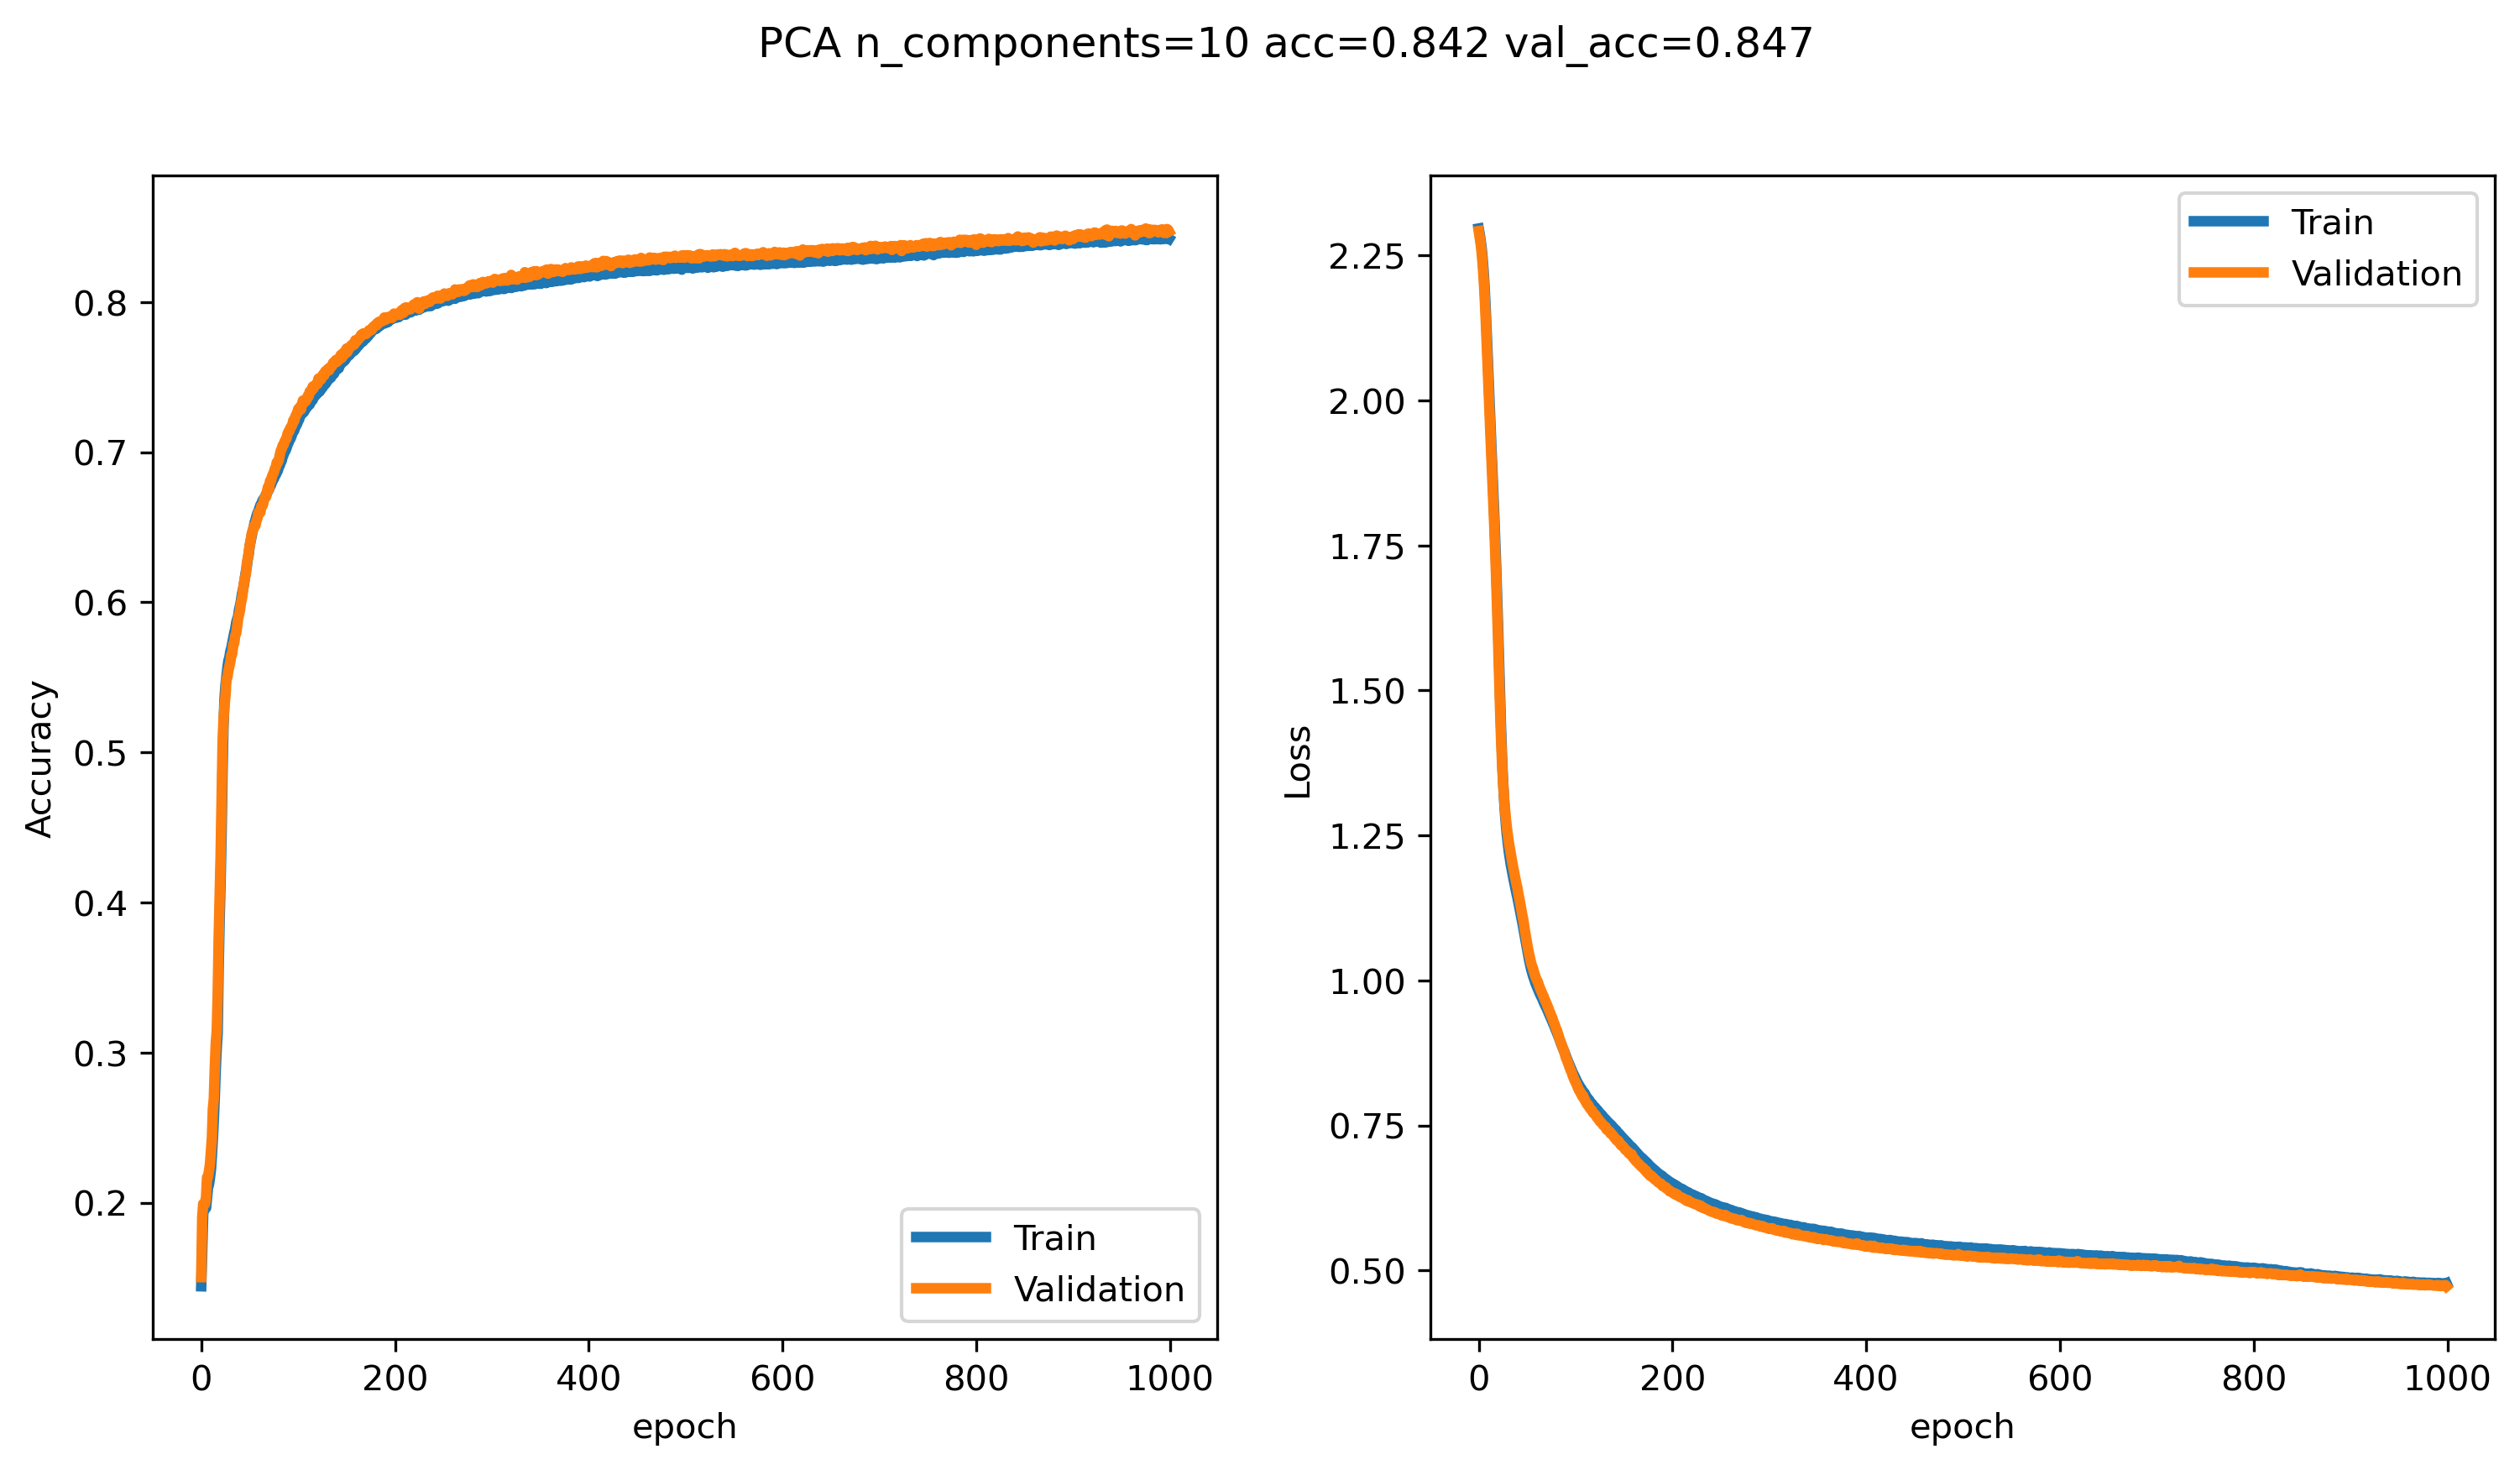

In [7]:
acc= np.mean(rec.history['accuracy'][-50:])
val_acc = np.mean(rec.history['val_accuracy'][-50:])

fig = plt.figure(figsize=(12,6), dpi=300)
plt.subplot(1,2,1)
plt.plot(rec.history['accuracy'], lw=3, label='Train')
plt.plot(rec.history['val_accuracy'], lw=3, label='Validation')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(rec.history['loss'], lw=3, label='Train')
plt.plot(rec.history['val_loss'], lw=3, label='Validation')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.suptitle(f'PCA n_components={n_components} acc={acc:.3f} val_acc={val_acc:.3f}')
plt.show()